In [53]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from data_loader import load
from torch import nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

In [54]:
#X_train, y_train: use for training and validating
#stratify_criterion: used to make sure each fold in cross validation has the same annotator agreement distribution
#X_test, y_test: only use for estimating final performance, prof really emphasized this (weird kink but ok)
X_train, y_train, stratify_criterion, X_test, y_test = load()
print(X_train.shape, y_train.shape, stratify_criterion.shape, X_test.shape, y_test.shape)

(96000, 548) (96000,) (96000,) (24000, 548) (24000,)


In [80]:
def train(dataloader, model, loss_fn, optimizer, show_progress):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 300 == 0 and show_progress:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, draw_confusion, y_names, show_progress):
    num_batches = len(dataloader)
    test_loss = 0

    confusion = None
    accuracy = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_vec = pred.argmax(1).cpu()
            y_vec = y.argmax(1).cpu()
            accuracy += accuracy_score(y_vec, pred_vec)
            confusion = confusion_matrix(y_vec, pred_vec) if confusion is None else confusion + confusion_matrix(pred_vec, y_vec) 

    test_loss /= num_batches
    accuracy /= num_batches
    if show_progress:
        print(f"Accuracy: {accuracy:>8f} Avg loss: {test_loss:>8f} \n")
    if draw_confusion:
        sns.heatmap(confusion, annot=True, cmap='Blues', xticklabels=y_names, yticklabels=y_names, fmt="d")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show(block=False)

def eval(model_fn, X, y, y_names, criterion, epochs, show_progress):
    skf = StratifiedKFold(3)
    scaler = StandardScaler()
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 
    for i, (train_index, validate_index) in enumerate(skf.split(X, criterion)):
        
        print(f"===============================\nFold {i+1}\n===============================")

        X_fold = X[train_index]
        scaler.fit(X_fold)
        X_fold = scaler.transform(X_fold)
        X_fold = torch.Tensor(X_fold).to(device)

        y_fold = y[train_index]
        y_fold = np.eye(np.max(y)+1)[y_fold]
        y_fold = torch.Tensor(y_fold).to(device)

        X_validate = X[validate_index]
        X_validate = scaler.transform(X_validate)
        X_validate = torch.Tensor(X_validate).to(device)

        y_validate = y[validate_index]
        y_validate = np.eye(np.max(y)+1)[y_validate]
        y_validate = torch.Tensor(y_validate).to(device)

        model = model_fn(None).to(device)

        train_dataloader = DataLoader(TensorDataset(X_fold, y_fold), batch_size=64)
        test_dataset = TensorDataset(X_validate, y_validate)
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss().to(device)
        for t in range(epochs):
            if show_progress:
                print(f"Epoch {t+1}\n-------------------------------")
            train(train_dataloader, model, loss_fn, optimizer, show_progress)
            test(test_dataloader, model, loss_fn, t == epochs-1, y_names, show_progress)


Fold 1


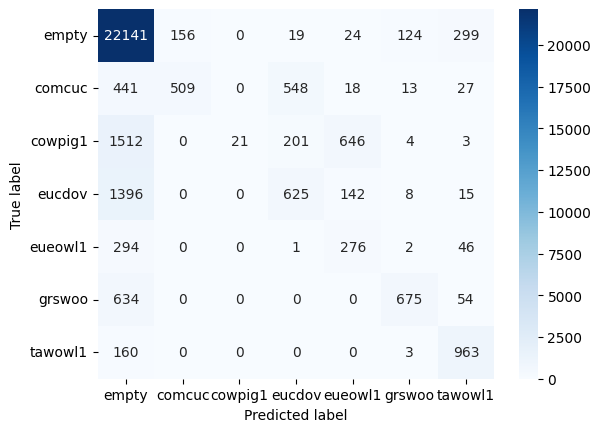

Fold 2


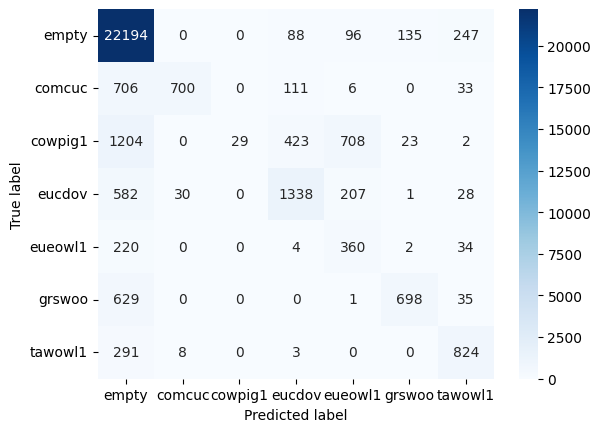

Fold 3


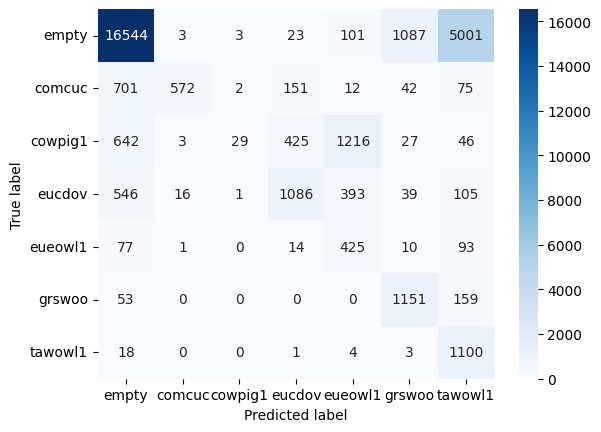

More complexity
Fold 1


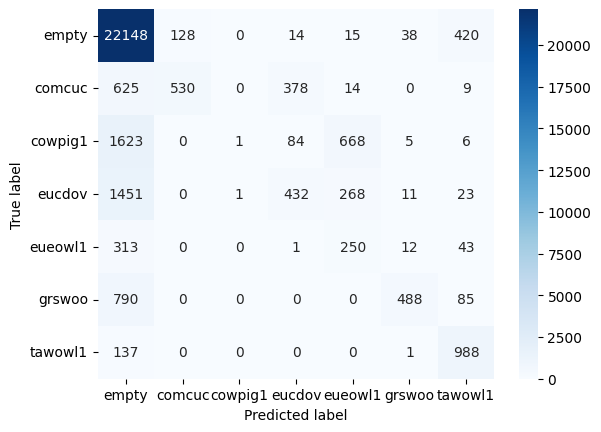

Fold 2


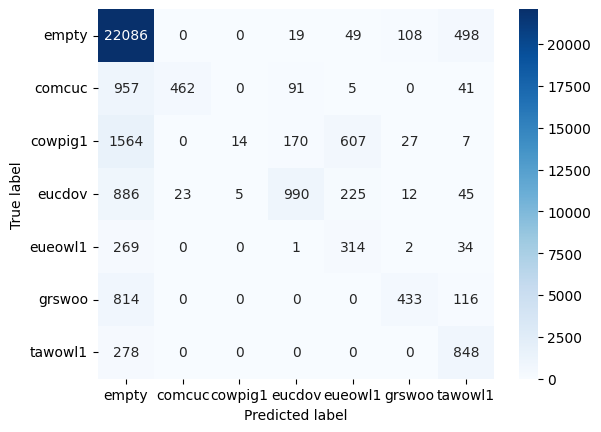

Fold 3


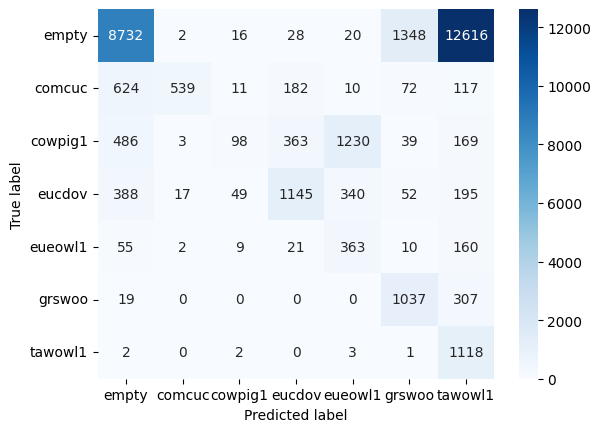

In [46]:
#Testing on entire dataset leads to massive bias towards empty class
model = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 7)
    )

eval(model, X_train, y_train, ['empty', 'comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion, 10, False)

print("More complexity")

model = lambda _: nn.Sequential(
        nn.Linear(548, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 7)
    )

eval(model, X_train, y_train, ['empty', 'comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion, 15, False)

In [40]:
X_train_no_empty = X_train[y_train != 0]
stratify_criterion_no_empty = stratify_criterion[y_train != 0]
y_train_no_empty = y_train[y_train != 0]
y_train_no_empty -= 1

X_test_no_empty = X_test[y_test != 0]
y_test_no_empty = y_test[y_test != 0]
y_test_no_empty -= 1

print(X_train_no_empty.shape, y_train_no_empty.shape, stratify_criterion_no_empty.shape, X_test_no_empty.shape, y_test_no_empty.shape)

(27715, 548) (27715,) (27715,) (6927, 548) (6927,)


Fold 1


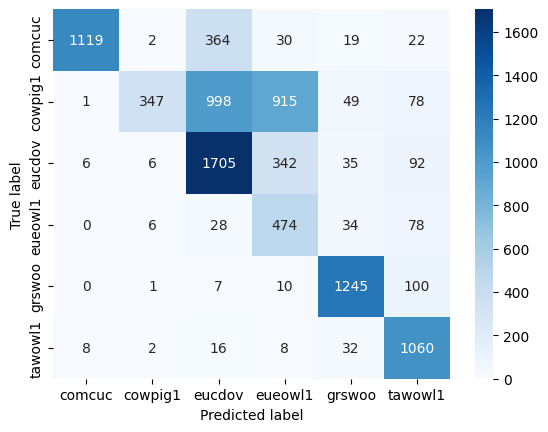

Fold 2


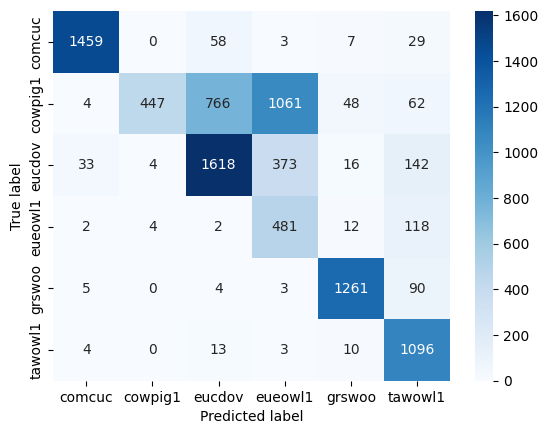

Fold 3


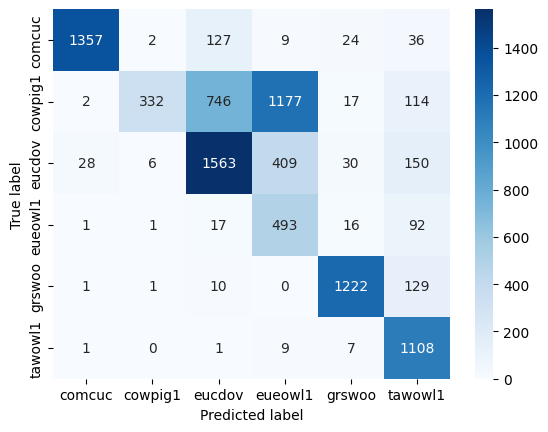

In [41]:
#Maybe NN is only useful for difference between birds
model = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 6)
    )
eval(model, X_train_no_empty, y_train_no_empty, ['comcuc', 'cowpig1', 'eucdov', 'eueowl1', 'grswoo', 'tawowl1'], stratify_criterion_no_empty, 15, False)

In [77]:
#undersampling empty class sadly does not seem to work
y_train_binary = np.copy(y_train)
y_train_binary[y_train_binary != 0] = 1
removed = np.random.choice(np.where(y_train_binary == 0)[0], size=len(y_train_binary[y_train_binary == 0])//2)
y_train_binary = np.delete(y_train_binary, removed)
X_train_binary = np.delete(X_train, removed, axis=0)


X_test_binary = X_test
y_test_binary = np.copy(y_test)
y_test_binary[y_test_binary != 0] = 1

print(X_train_binary.shape, y_train_binary.shape, X_test_binary.shape, y_test_binary.shape)

(69169, 548) (69169,) (24000, 548) (24000,)


Fold 1


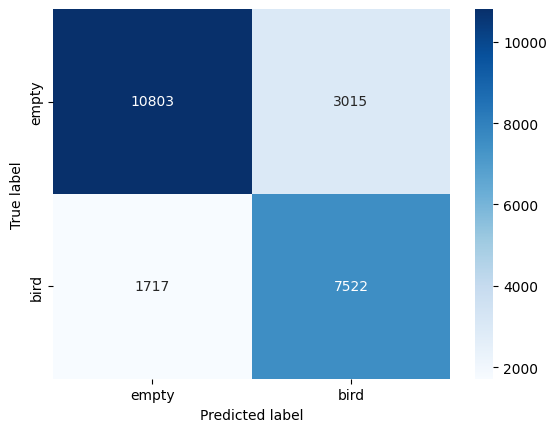

Fold 2


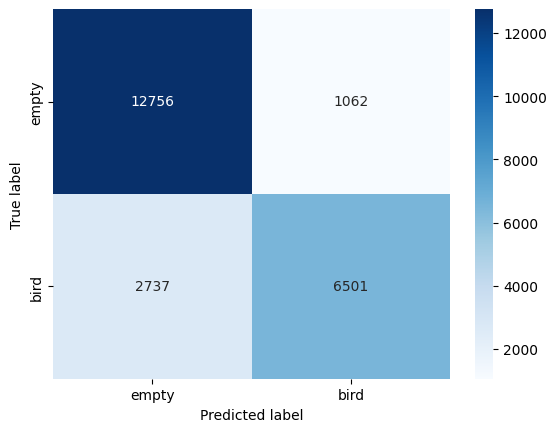

Fold 3


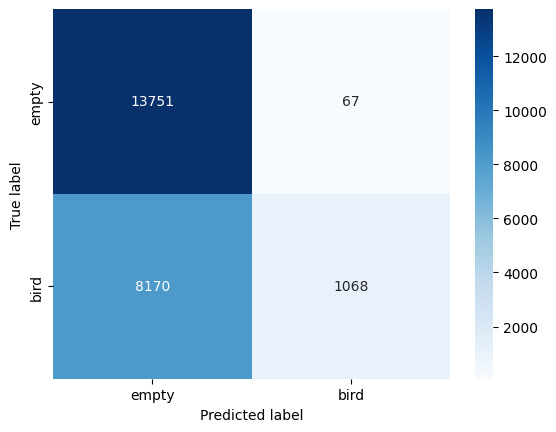

In [79]:
model = lambda _: nn.Sequential(
        nn.Linear(548, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 2)
    )
eval(model, X_train_binary, y_train_binary, ['empty', 'bird'], y_train_binary, 15, False)